<a href="https://colab.research.google.com/github/nguyetvo/CBD-Melanoma_Classification/blob/master/melanoma_classification_pre_trained_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Melanoma Classification

We predict whether it's beingn or malignant.

In [ ]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import numpy as np 
import pandas as pd
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
#from livelossplot import 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from lightgbm import LGBMClassifier

Using TensorFlow backend.


In [ ]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [ ]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [ ]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [ ]:
dist=train['target'].value_counts()
print("Benign cases are",(32542/(32542+584))*100)


Benign cases are 98.23703435367989


1.7% patients in dataset have malignant cancer.

**anatom_site_general_challenge** in the dataset refers to the location of the skin cancer given in the image.

In [ ]:
labels=train['anatom_site_general_challenge'].value_counts().index
values=train['anatom_site_general_challenge'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()


The cancer is found on the torso in more than half of the patients in dataset

Now we look at the diagnosis provided by Dermatologists

In [ ]:
labels=train['diagnosis'].value_counts().index[1:]
values=train['diagnosis'].value_counts().values[1:]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()


In [ ]:
new=train.drop(labels=['image_name','patient_id','sex','age_approx','anatom_site_general_challenge','target'],axis=1)
pd.crosstab(new['diagnosis'].values,new['benign_malignant'])

benign_malignant                    benign  malignant
row_0                                                
atypical melanocytic proliferation       1          0
cafe-au-lait macule                      1          0
lentigo NOS                             44          0
lichenoid keratosis                     37          0
melanoma                                 0        584
nevus                                 5193          0
seborrheic keratosis                   135          0
solar lentigo                            7          0
unknown                              27124          0

Most benign cases are diagnosed as **nevus**. 

In [ ]:
df_0=train[train['target']==0].sample(2000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [ ]:
def get_image(img_name,is_train=True,transform=False):
    if is_train:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
    else:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
    if transform:
        img = load_image(path, img_name)
    else:
        path = os.path.join(path,img_name+'.jpg')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_data(df,rows,cols,is_train=True,transform=False):
    df.reset_index(inplace=True,drop=True)
    fig = plt.figure(figsize=(6,6),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_name = df.loc[i-1,'image_name']
            title = 'Patient id: '+df.loc[i-1,'patient_id']+'\n'\
              +'Site: '+str(df.loc[i-1,'anatom_site_general_challenge'])+'\n'\
              +'Sex: '+str(df.loc[i-1,'sex'])+'\n'\
              +'Approximate Age: '+str(int(df.loc[i-1,'age_approx']))
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_name,is_train,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

Before going any further with training let's take a look at sample photos from both classes.

Benign Cases


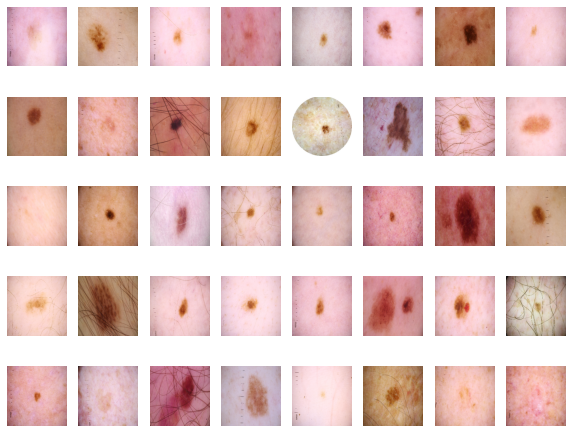

In [ ]:
print('Benign Cases')
benign=[]
df_benign=df_0.sample(40)
df_benign=df_benign.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_benign['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    benign.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(benign):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

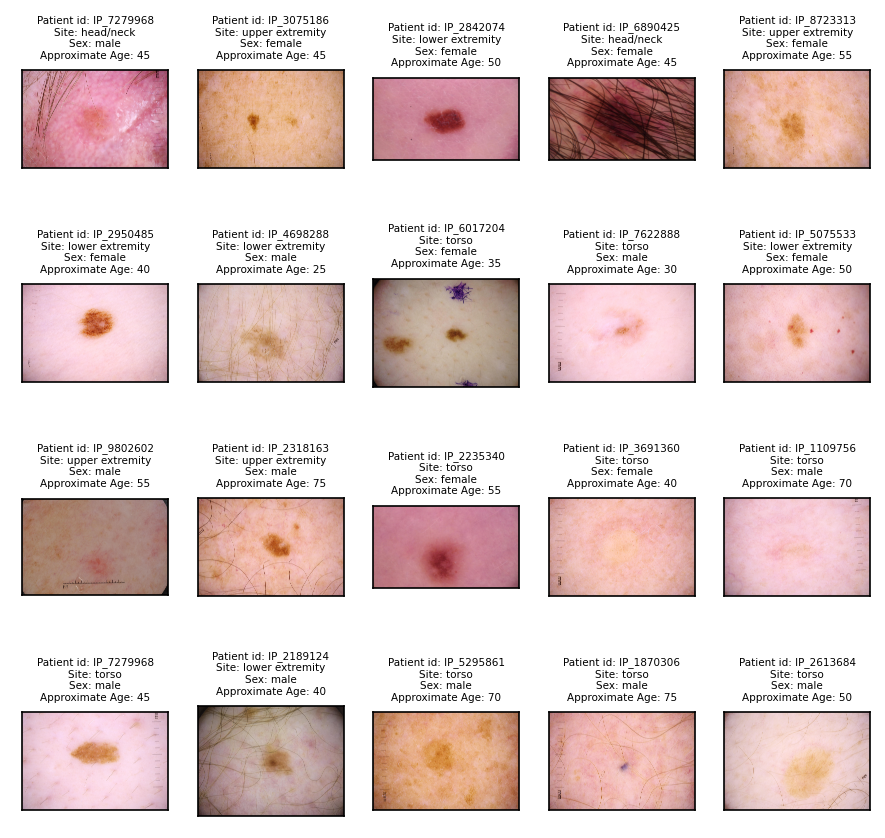

In [ ]:
fig = show_data(train[train['benign_malignant']=='benign'].iloc[:20,:],4,5)
fig.tight_layout()

Malignant Cases


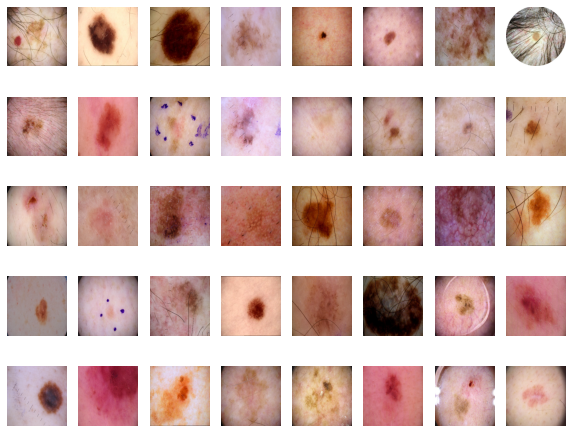

In [ ]:
print('Malignant Cases')
malignant=[]
df_malignant=df_1.sample(40)
df_malignant=df_malignant.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_malignant['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    malignant.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(malignant):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

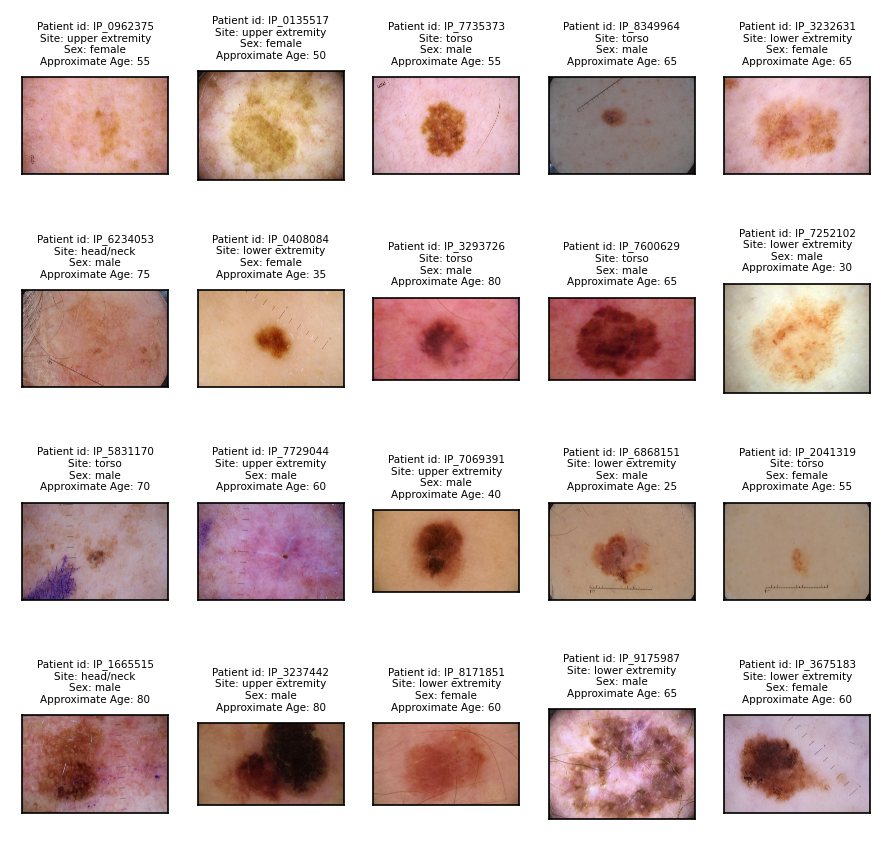

In [ ]:
fig = show_data(train[train['benign_malignant']=='malignant'].iloc[:20,:],4,5)
fig.tight_layout()

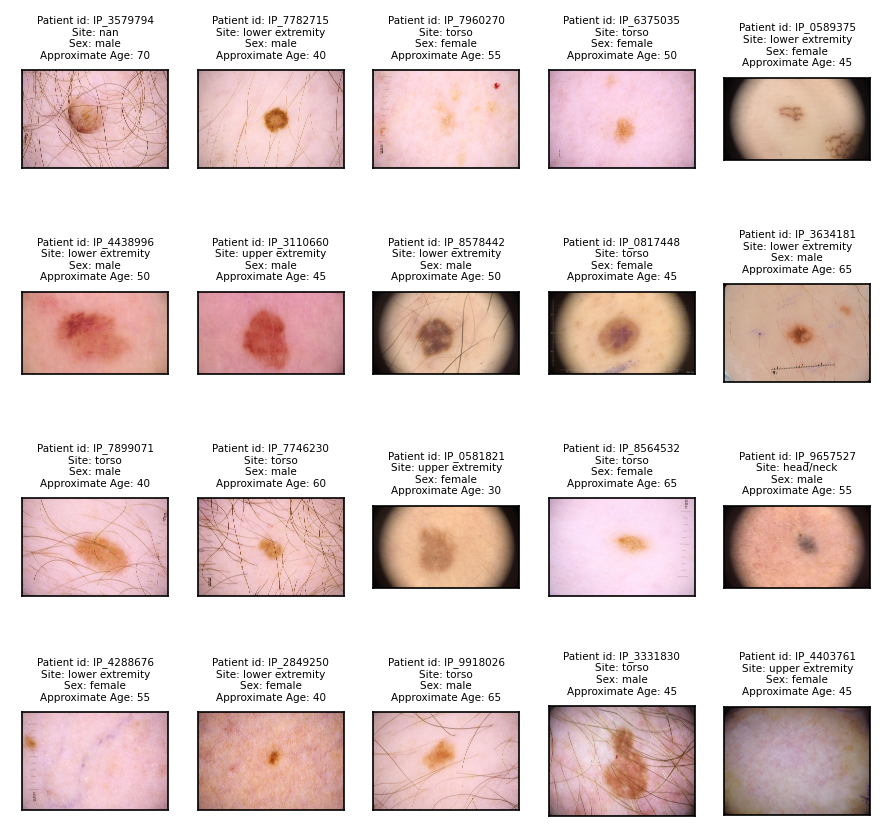

In [ ]:
fig = show_data(test.iloc[:20,:],4,5,is_train=False)
fig.tight_layout()

## Preparing the Datasets

In [ ]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [ ]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

I'll do some very basic preprocessing like 
* normalizing
* reshaping
* augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False,
    batch_size=8,
    class_mode='raw')



Found 2067 validated image filenames.
Found 517 validated image filenames.


## Modelling
I'm using pretrained VGG-16 and adding the last dense layer.

In [ ]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg16_model(1)

58892288/58889256 [==============================] - 1s 0us/step


Also, because of class imbalance it's better to use **focal loss** rather than normal **binary_crossentropy**.

In [ ]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [ ]:
opt = Adam(lr=1e-5)
vgg_conv.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [ ]:
nb_epochs = 2
batch_size=8
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 258 and 64


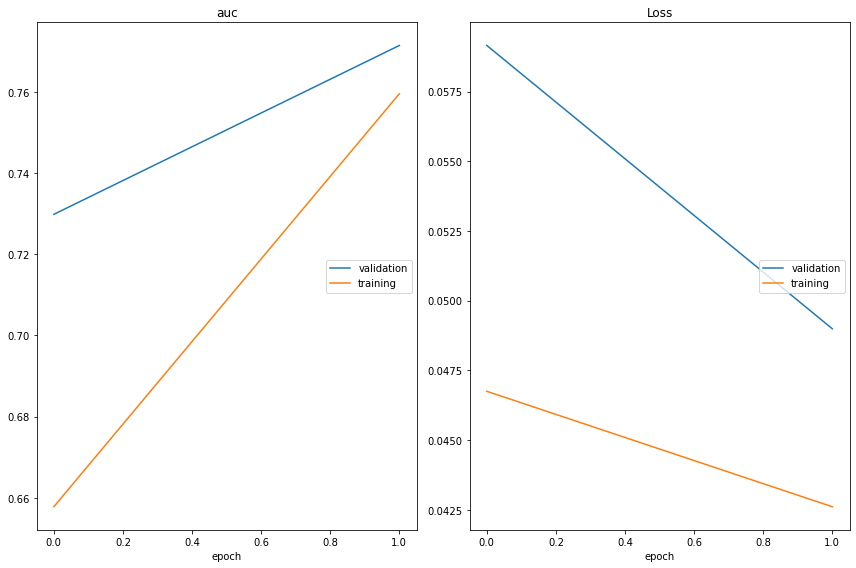

auc
	validation       	 (min:    0.730, max:    0.771, cur:    0.771)
	training         	 (min:    0.658, max:    0.760, cur:    0.760)
Loss
	validation       	 (min:    0.049, max:    0.059, cur:    0.049)
	training         	 (min:    0.043, max:    0.047, cur:    0.043)


In [ ]:
cb=[PlotLossesKeras()]
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=nb_val_steps)

## Test

In [ ]:
target=[]
for path in df_test['images']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=vgg_conv.predict(img)
    target.append(prediction[0][0])

submission['target']=target
    
        

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.head()

image_name    target
0  ISIC_0052060  0.219177
1  ISIC_0052349  0.165310
2  ISIC_0058510  0.193230
3  ISIC_0073313  0.148713
4  ISIC_0073502  0.326066

**Using LGBM Classifier to classify the test data into benign/malignant.**

**Resizing the images**

I choose the size 256x256 of each image

In [ ]:
#Size to resize(256,256,3)
img_size = 256

#Paths to train and test images
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

def resize_image(img):
    old_size = img.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1],new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0,0,0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def load_image(path, img_id):
    path = os.path.join(path,img_id+'.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img = resize_image(img)
    new_img = preprocess_input(new_img)
    return new_img

**Resized images of Benign Tumours**

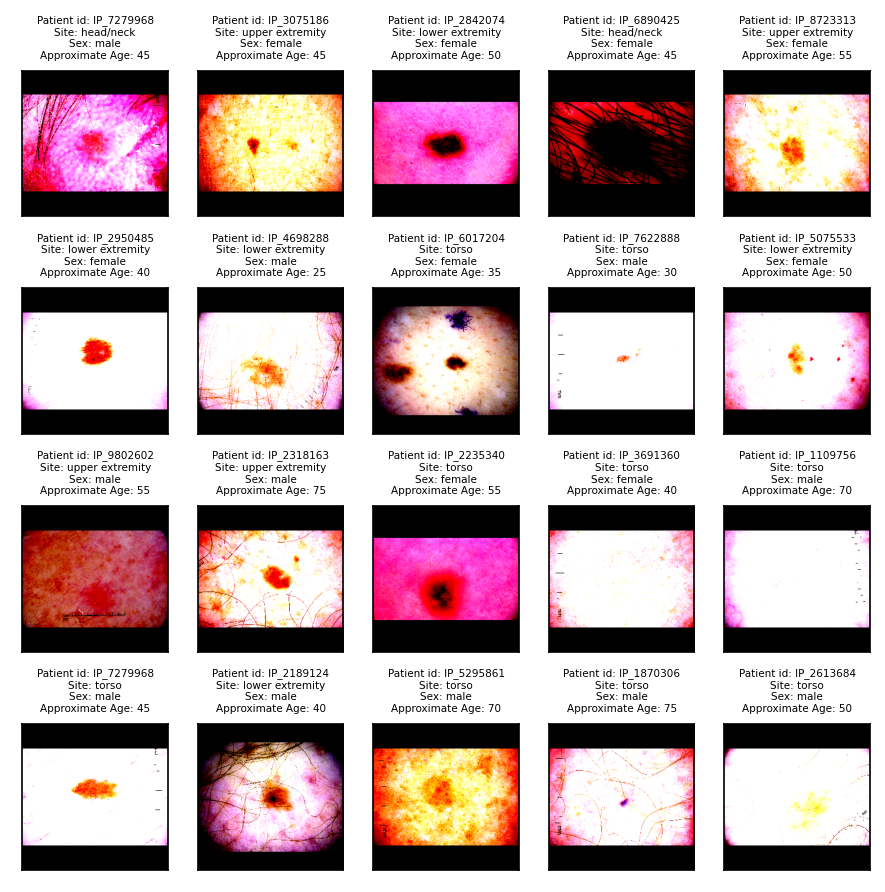

In [ ]:
fig = show_data(train[train['benign_malignant']=='benign'].iloc[:20,:],4,5,transform=True)
fig.tight_layout()

**Resized images of Malignant Tumours**

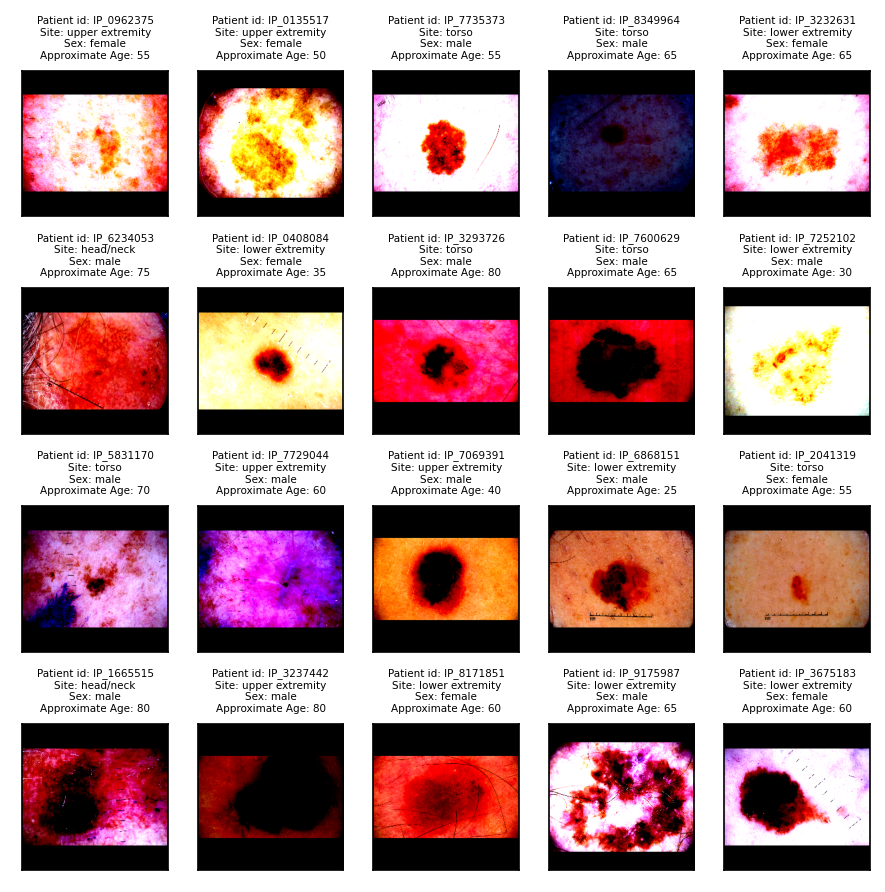

In [ ]:
fig = show_data(train[train['benign_malignant']=='malignant'].iloc[:20,:],4,5,transform=True)
fig.tight_layout()

**Images from the test set.**

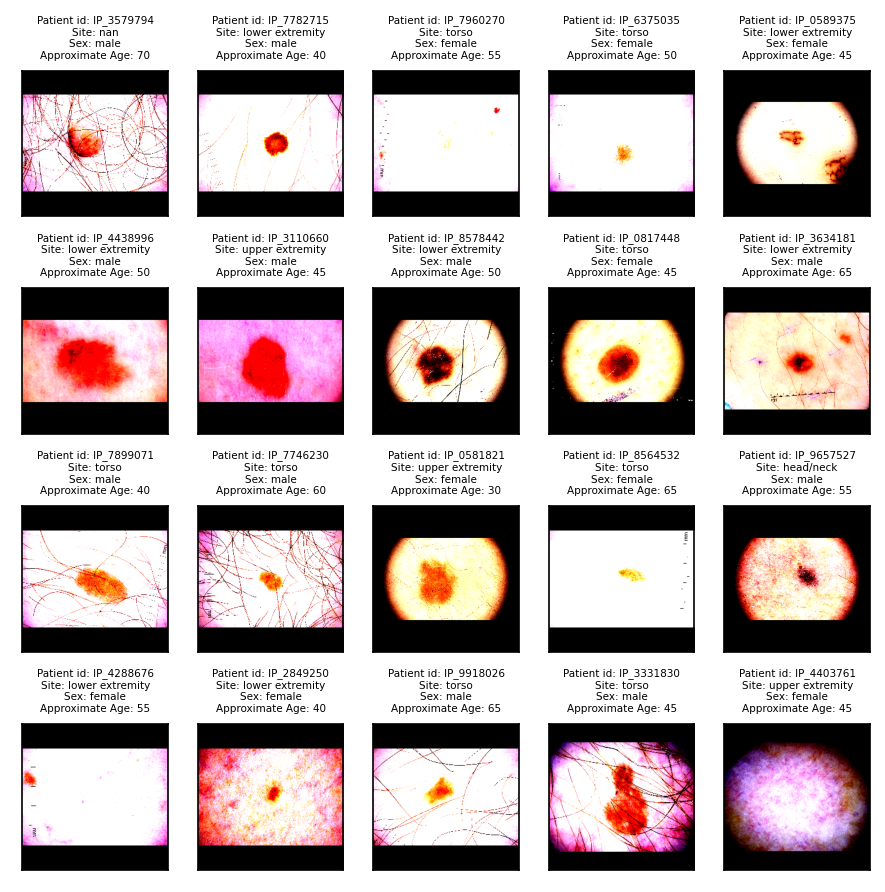

In [ ]:
fig = show_data(test.iloc[:20,:],4,5,is_train=False,transform=True)
fig.tight_layout()

**Extract features from Images**

This entire process of extraction of features from Images using DenseNet121. I use a public dataset: https://www.kaggle.com/anshuls235/melanomaextractedfeatures of Anshuls author. This dataset conatins all the extracted features and can be used for everyone.

The process of extracting Image features using a pretrained Neural network. The pretrained NN here is a DenseNet121. Per image will be extracting 256 features for both the train and test set.
<img src='https://imgur.com/wWHWbQt.jpg' style="width:800px;height:200px;">
**DenseNet Architecture**
<img src='https://imgur.com/oiTdqJL.jpg' style="width:500px;height:300px;">
Normally DenseNet121 would output 1024 features after GlobalAveragePooling and pooled 4 features each.

**Train the model and predict the results**

**Using LGBM Classifier to classify the test data into benign/malignant**

In [ ]:
train_feats = pd.read_csv('../input/melanomaextractedfeatures/train_img_features.csv')
test_feats = pd.read_csv('../input/melanomaextractedfeatures/test_img_features.csv')
train_feats.set_index(train_feats.columns[0],inplace=True)
test_feats.set_index(test_feats.columns[0],inplace=True)

In [ ]:
#Combine the image and tabular data
df_train_full = pd.merge(train, train_feats, how='inner', left_on='image_name', right_index=True)
df_test_full = pd.merge(test, test_feats, how='inner', left_on='image_name', right_index=True)

#Drop the unwanted columns
train1 = df_train_full.drop(['image_name','patient_id','diagnosis','benign_malignant'],axis=1)
test1 = df_test_full.drop(['image_name','patient_id'],axis=1)

#Label Encode categorical features
train1.sex.fillna('NaN',inplace=True)
test1.sex.fillna('NaN',inplace=True)
train1.anatom_site_general_challenge.fillna('NaN',inplace=True)
test1.anatom_site_general_challenge.fillna('NaN',inplace=True)
le_sex = LabelEncoder()
le_site = LabelEncoder()
train1.sex = le_sex.fit_transform(train1.sex)
test1.sex = le_sex.transform(test1.sex)
train1.anatom_site_general_challenge = le_site.fit_transform(train1.anatom_site_general_challenge)
test1.anatom_site_general_challenge = le_site.transform(test1.anatom_site_general_challenge)

In [ ]:
folds = StratifiedKFold(n_splits= 10, shuffle=True)
oof_preds = np.zeros(train1.shape[0])
sub_preds = np.zeros(test1.shape[0])
feature_importance_df = pd.DataFrame()
features = [f for f in train1.columns if f != 'target']
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train1[features], train1['target'])):
    train_X, train_y = train1[features].iloc[train_idx], train1['target'].iloc[train_idx]
    valid_X, valid_y = train1[features].iloc[valid_idx], train1['target'].iloc[valid_idx]
    clf = LGBMClassifier(
        #device='gpu',
        n_estimators=1000,
        learning_rate=0.001,
        max_depth=8,
        colsample_bytree=0.5,
        num_leaves=50,
        random_state=0
    )
    print('*****Fold: {}*****'.format(n_fold))
    clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (valid_X, valid_y)], 
            eval_metric= 'auc', verbose= 20, categorical_feature=[0,2],early_stopping_rounds= 20)

    oof_preds[valid_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test1[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

*****Fold: 0*****
Training until validation scores don't improve for 20 rounds
[20]	training's auc: 0.942761	training's binary_logloss: 0.0859404	valid_1's auc: 0.832862	valid_1's binary_logloss: 0.0872866
[40]	training's auc: 0.946485	training's binary_logloss: 0.0835036	valid_1's auc: 0.83947	valid_1's binary_logloss: 0.0865513
[60]	training's auc: 0.951112	training's binary_logloss: 0.0813695	valid_1's auc: 0.847836	valid_1's binary_logloss: 0.0859247
[80]	training's auc: 0.955059	training's binary_logloss: 0.0794138	valid_1's auc: 0.852407	valid_1's binary_logloss: 0.0852598
Early stopping, best iteration is:
[73]	training's auc: 0.953896	training's binary_logloss: 0.0800696	valid_1's auc: 0.85325	valid_1's binary_logloss: 0.0854659
Fold  1 AUC : 0.853250
*****Fold: 1*****
Training until validation scores don't improve for 20 rounds
[20]	training's auc: 0.940148	training's binary_logloss: 0.0858273	valid_1's auc: 0.848212	valid_1's binary_logloss: 0.0873133
Early stopping, best ite

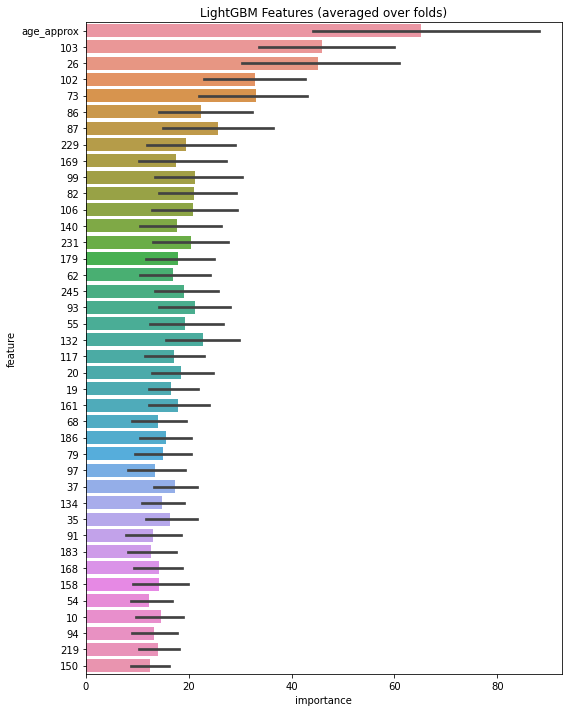

In [ ]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.savefig('feature_importance.jpg')
    
display_importances(feature_importance_df)

In [ ]:
submission = pd.DataFrame({
    "image_name": test.image_name, 
    "target": sub_preds
})
submission.to_csv('submission.csv', index=False)
submission.head()

image_name    target
0  ISIC_0052060  0.017167
1  ISIC_0052349  0.017122
2  ISIC_0058510  0.017081
3  ISIC_0073313  0.017084
4  ISIC_0073502  0.017776

After using pretrained model VGG16, it gives the highest score of target. The second is LGBM. 

Next step, I will continually train this datasets in other models to classify the best model to give high score.